# Spiking network demo of stable sequences through spatiotemporal modulation

In [1]:
%matplotlib inline
from copy import deepcopy as copy
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
from scipy.sparse import csc_matrix
import os
import sys

from aux import Generic
from disp import set_font_size, get_spaced_colors
from ntwk import LIFNtwkG, join_w

cc = np.concatenate

# PARAMS
## NEURON AND NETWORK MODEL
M = Generic(
    # Excitatory membrane
    C_M_E=1e-6,  # membrane capacitance
    G_L_E=.1e-3,  # membrane leak conductance (T_M (s) = C_M (F/cm^2) / G_L (S/cm^2))
    E_L_E=-.06,  # membrane leak potential (V)
    V_TH_E=-.05,  # membrane spike threshold (V)
    T_R_E=.002,  # refractory period (s)
    
    # Inhibitory membrane
    #C_M_I=1e-6,
    #G_L_E=.1e-3, 
    #E_L_I=-.06,
    #V_TH_E=-.05,
    #T_R_I=.002,
    
    # syn rev potentials and decay times
    E_E=0, E_I=-.08, E_A=-0.1, T_E=.002, T_I=.002, T_A=0.01,

    # NTWK ARCHITECTURE
    N_L=321,  # num chain links
    N_L_E=30,  # num E nrns per chain link
    N_I=200, # num I nrns (unused)
    
    W_R_E_E_L=1.4e-5,  # E-E recurrent cxns w/in chain link
    W_R_E_E_F={'S': .65e-5, 'B': 1.e-5, 'F': 1.4e-5},  # E-E feed-forward link cxns for diff speeds
    
    W_A=.06e-3, # adaptation weight for all neurons
    
    W_R_E_I=0,  # recurrent I->E weights
    W_R_I_E=0,  # recurrent E->I weights
    
    W_U_E_I=2e-5,  # upstream inh weights to E chain
    W_U_E_E=4e-6,  #0,  # upstread exc weights to E chain
    
    P_CXN_E_E=.6,
    P_CXN_E_I=1.,
    
    # MODULATION STRENGTH
    FQ_SPK_U=800,  # modulatory input frq
    PERIOD_T_U=.1,  # temporal mod period
    PERIOD_S_U=116.,  # spatial mod period
    
    # OTHER INPUTS
    SGM_N=.1e-9,  # noise level (A*sqrt(s))
    I_EXT_B=0,  # additional baseline current input
)

M.N_E = M.N_L * M.N_L_E
M.N_N = M.N_E + M.N_I
M.X_E = cc([np.repeat(cl, M.N_L_E) for cl in range(M.N_L)])

## SMLN
S = Generic(RNG_SEED=0, DT=.0005, T=0.4)

print('T_M_E =', 1000*M.C_M_E/M.G_L_E, 'ms')  # E cell membrane time constant (C_m/g_m)

T_M_E = 10.0 ms


### Helper functions for defining connectivity

In [2]:
def rand_bin_array_with_percentage_ones(l, num_ones):
    a = np.zeros(l)
    a[:num_ones] = 1
    np.random.shuffle(a)
    return a


def sprs_mat_with_rand_percent_cnxns(shape, row_percent):
    num_ones = int(row_percent * shape[0])
    stacked = np.stack([rand_bin_array_with_percentage_ones(shape[0], num_ones) for i in range(shape[1])])
    return stacked

In [3]:
# see D1 for specific comments on these functions

## E-E weights
def make_w_r_e(m):
    w_r_e = np.zeros([m.N_N]*2)

    # make spatial profile
    sp = np.repeat('', m.N_L)

    for l in range(m.N_L):
        if 0 <= (l%m.PERIOD_S_U) < (.5*m.PERIOD_S_U):
            sp[l] = 'B'
        elif (.5*m.PERIOD_S_U) <= (l%m.PERIOD_S_U) < (.75*m.PERIOD_S_U):
            sp[l] = 'S'
        else:
            sp[l] = 'F'
    
    # between links
    # loop through links assigning correct feed forward weights
    for l in range(m.N_L-1):
        col = (l*m.N_L_E, (l+1)*m.N_L_E)  # src link
        row = ((l+1)*m.N_L_E, (l+2)*m.N_L_E)  # targ link 
        w_r_e[row[0]:row[1], col[0]:col[1]] = m.W_R_E_E_F[sp[l]]*np.ones([m.N_L_E]*2)
    
    #w_r_e_e = m.W_R_E_E_F * np.kron(np.eye(m.N_L, k=-1), np.ones([m.N_L_E]*2))
    
    # within links
    for l in range(m.N_L):
        
        w_r_e[(l * m.N_L_E):((l+1) * m.N_L_E), (l * m.N_L_E):((l+1) * m.N_L_E)] = \
            m.W_R_E_E_L * sprs_mat_with_rand_percent_cnxns((m.N_L_E, m.N_L_E), m.P_CXN_E_E)

    w_r_e[m.N_E:, :m.N_E] = m.W_R_E_I * sprs_mat_with_rand_percent_cnxns((m.N_E, m.N_I), m.P_CXN_E_I)
    
    return w_r_e

def make_w_r_i(m):
    w_r_i = np.zeros((m.N_N, m.N_N))
    w_r_i[:m.N_E, m.N_E:] = m.W_R_I_E * np.ones([m.N_E, m.N_I])
    return w_r_i

In [4]:
def get_w_r_e_e_f_profile(m):
    w_r_e_e_f = np.nan * np.zeros(m.N_L)

    for l in range(m.N_L):
        if 0 <= (l%m.PERIOD_S_U) < (.5*m.PERIOD_S_U):
            w_r_e_e_f[l] = m.W_R_E_E_F['B']
        elif (.5*m.PERIOD_S_U) <= (l%m.PERIOD_S_U) < (.75*m.PERIOD_S_U):
            w_r_e_e_f[l] = m.W_R_E_E_F['S']
        else:
            w_r_e_e_f[l] = m.W_R_E_E_F['F']
            
    return w_r_e_e_f


def get_w_u_e_w_u_i_profile(m):
    
    w_u_e = np.zeros(m.N_L)
    w_u_i = np.zeros(m.N_L)
    
    for l in range(m.N_L):
        if (.25*m.PERIOD_S_U) <= (l%m.PERIOD_S_U) < (.75*m.PERIOD_S_U):
            w_u_e[l] = m.W_U_E_E
        else:
            w_u_i[l] = m.W_U_E_I

    return w_u_e, w_u_i

## Analysis helper functions

In [5]:
def decode_x(rsp, wdw=.002, min_spk=5):
    """Decode position from spike times and locations via a running median"""
    x_mdn = np.nan * np.zeros(len(rsp.t))
    # get exc spikes
    me = rsp.spks_c < rsp.m.N_E
    spks_t = rsp.spks_t[me]
    spks_x = rsp.m.X_E[rsp.spks_c[me]]
    
    for ct, t_ in enumerate(rsp.t):
        mt = (t_ - wdw/2 <= spks_t) & (spks_t < t_ + wdw/2)
        if mt.sum() >= min_spk:
            x_mdn[ct] = np.nanmedian(spks_x[mt])
        
    return x_mdn

# Spatial intrinsic speed modulation, constant input

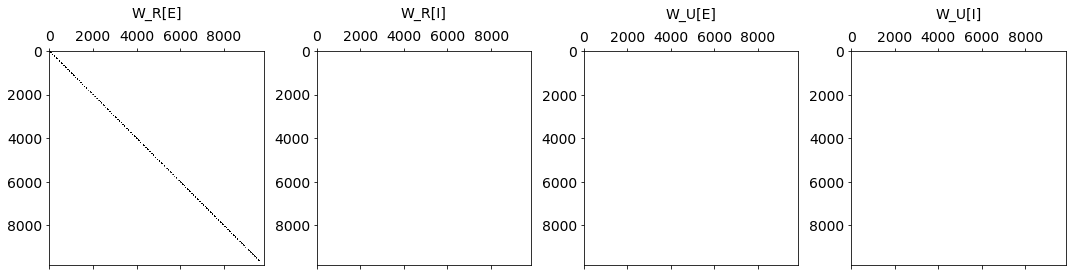

In [6]:
def make_w_u_e(m):
    w_u_e = np.block([
            [ 0.01 * np.eye(m.N_L_E), np.zeros([m.N_L_E, m.N_N]) ],
            [ np.zeros([m.N_N - m.N_L_E, m.N_N + m.N_L_E]) ],
        ])
    return w_u_e


def make_w_u_i(m):
    w_u_i = np.zeros([m.N_N, m.N_L_E + m.N_N])
    return w_u_i


m = copy(M)

np.random.seed(seed=0)

# inputs
t = np.arange(0, S.T, S.DT)
t_u = [.01, .013]
t_mask = (t_u[0] <= t) & (t < t_u[1])

## external currents
i_ext = m.SGM_N/S.DT * np.random.randn(len(t), m.N_N) + m.I_EXT_B

## inp spks
spks_u_base = np.zeros((len(t), m.N_L_E + m.N_N), dtype=int)

# trigger inputs
tmp = cc([np.ones(m.N_L_E, int), np.zeros(m.N_L_E*(t_mask.sum()-1))])
spks_u_base[t_mask, :m.N_L_E] = tmp[np.random.permutation(len(tmp))].reshape(t_mask.sum(), m.N_L_E)

# input weights
w_u = {
    # localized inputs to trigger activation from start of chain
    'E': make_w_u_e(m),

    # global inhibitory inputs across chain
    'I': make_w_u_i(m),
}

# chain weights
w_r = {
    'E': make_w_r_e(m),
    'I': make_w_r_i(m),
    'A': m.W_A * np.eye(m.N_N),
}

fig, axs = plt.subplots(1, 4, figsize=(15, 4), tight_layout=True)
axs[0].matshow(w_r['E'], vmin=0, vmax=10e-6, cmap='binary')
axs[0].set_title('W_R[E]\n')
axs[1].matshow(w_r['I'], vmin=0, vmax=10e-6, cmap='binary')
axs[1].set_title('W_R[I]\n')

axs[2].matshow(w_u['E'], vmin=0, vmax=10e-6, cmap='binary')
axs[2].set_title('W_U[E]\n')
axs[3].spy(w_u['I'], markersize=1)
axs[3].set_title('W_U[I]\n')

for ax in axs.flatten():
    set_font_size(ax, 14)

(0, 400.0)

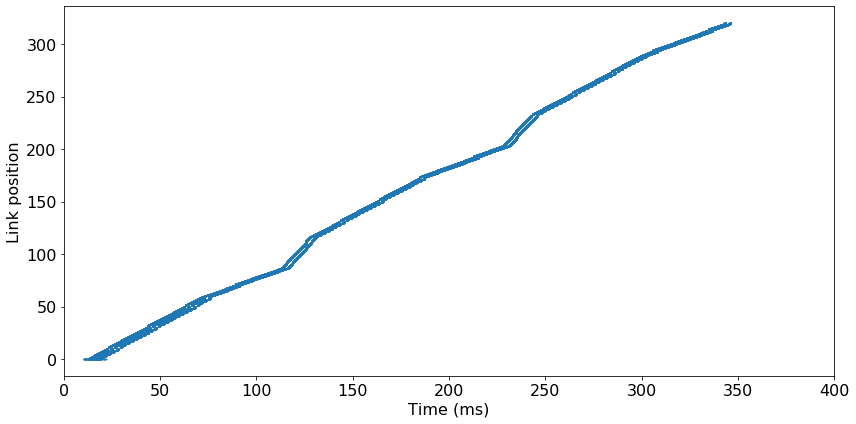

In [7]:
# upstream inputs
spks_u = spks_u_base.copy()
spks_u[:, m.N_L_E:-(m.N_I)] = np.random.poisson(m.FQ_SPK_U * S.DT, (len(t), m.N_E))

ntwk = LIFNtwkG(
    c_m=m.C_M_E,
    g_l=m.G_L_E,
    e_l=m.E_L_E,
    v_th=m.V_TH_E,
    v_r=m.E_L_E,
    t_r=m.T_R_E,
    e_s={'E': m.E_E, 'I': m.E_I, 'A': m.E_A},
    t_s={'E': m.T_E, 'I': m.T_E, 'A': m.T_A},
    w_r=w_r,
    w_u=w_u)

# initial condition
clamp = Generic(v={0: np.repeat(m.E_L_E, m.N_N)}, spk={})

# run smln
rsp = ntwk.run(dt=S.DT, clamp=clamp, i_ext=i_ext, spks_u=spks_u)
rsp.spks_u = spks_u.copy()
rsp.m = copy(m)
    
fig, ax = plt.subplots(1, 1, figsize=(12, 6), tight_layout=True)
spks_t = rsp.spks_t[rsp.spks_c < M.N_E]
spks_c = rsp.spks_c[rsp.spks_c < M.N_E]
spks_x = M.X_E[spks_c]
ax.scatter(1000*spks_t, spks_x, s=1)
ax.set_xlabel('Time (ms)')
ax.set_ylabel('Link position')
set_font_size(ax, 16)
ax.set_xlim(0, 1000*S.T)

# Variable intrinsic speed, constant spatially distributed modulation

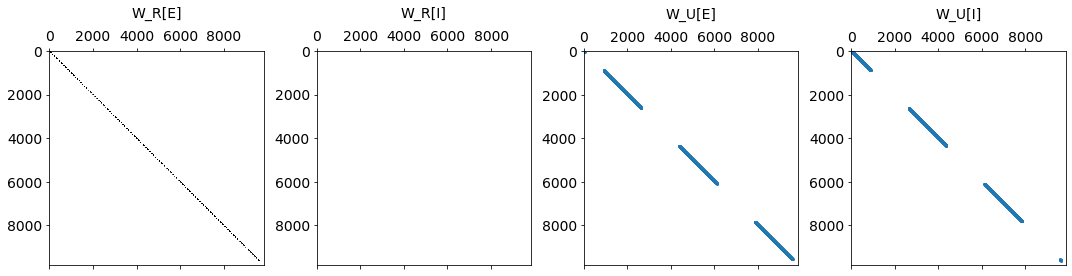

In [8]:
def make_w_u_e(m):
    w_u_e = np.block([
        [ 0.01 * np.eye(m.N_L_E), np.zeros([m.N_L_E, m.N_N]) ],
        [ np.zeros([m.N_N - m.N_L_E, m.N_N + m.N_L_E]) ],
    ])
    
    w_e_mod = np.zeros((m.N_N, m.N_N))
    
    for l in range(m.N_L):
        if (.25*m.PERIOD_S_U) <= (l%m.PERIOD_S_U) < (.75*m.PERIOD_S_U):
            start = l*m.N_L_E
            end = (l+1)*m.N_L_E
            w_e_mod[start:end, start:end] = m.W_U_E_E*np.eye(m.N_L_E)
    
    w_u_e[:, m.N_L_E:] = w_e_mod
    return csc_matrix(w_u_e)


def make_w_u_i(m):
    w_u_i = np.zeros([m.N_N, m.N_L_E + m.N_N])
    
    w_i_mod = np.zeros((m.N_N, m.N_N))
    
    for l in range(m.N_L):
        if (.25*m.PERIOD_S_U) <= (l%m.PERIOD_S_U) < (.75*m.PERIOD_S_U):
            continue
        else:
            start = l*m.N_L_E
            end = (l+1)*m.N_L_E
            w_i_mod[start:end, start:end] = m.W_U_E_I*np.eye(m.N_L_E)
    
    w_u_i[:, m.N_L_E:] = w_i_mod
    return csc_matrix(w_u_i)


m = copy(M)

np.random.seed(seed=0)

# inputs
t = np.arange(0, S.T, S.DT)
t_u = [.01, .013]
t_mask = (t_u[0] <= t) & (t < t_u[1])

## external currents
i_ext = m.SGM_N/S.DT * np.random.randn(len(t), m.N_N) + m.I_EXT_B

## inp spks
spks_u_base = np.zeros((len(t), m.N_L_E + m.N_N), dtype=int)

# trigger inputs
tmp = cc([np.ones(m.N_L_E, int), np.zeros(m.N_L_E*(t_mask.sum()-1))])
spks_u_base[t_mask, :m.N_L_E] = tmp[np.random.permutation(len(tmp))].reshape(t_mask.sum(), m.N_L_E)

# input weights
w_u = {
    # localized inputs to trigger activation from start of chain
    'E': make_w_u_e(m),

    # global inhibitory inputs across chain
    'I': make_w_u_i(m),
}

# chain weights
w_r = {
    'E': make_w_r_e(m),
    'I': make_w_r_i(m),
    'A': m.W_A * np.eye(m.N_N),
}


fig, axs = plt.subplots(1, 4, figsize=(15, 4), tight_layout=True)
axs[0].matshow(w_r['E'], vmin=0, vmax=10e-6, cmap='binary')
axs[0].set_title('W_R[E]\n')
axs[1].matshow(w_r['I'], vmin=0, vmax=10e-6, cmap='binary')
axs[1].set_title('W_R[I]\n')

axs[2].spy(w_u['E'], markersize=1)
axs[2].set_title('W_U[E]\n')
axs[3].spy(w_u['I'], markersize=1)
axs[3].set_title('W_U[I]\n')

for ax in axs.flatten():
    set_font_size(ax, 14)

(0, 400.0)

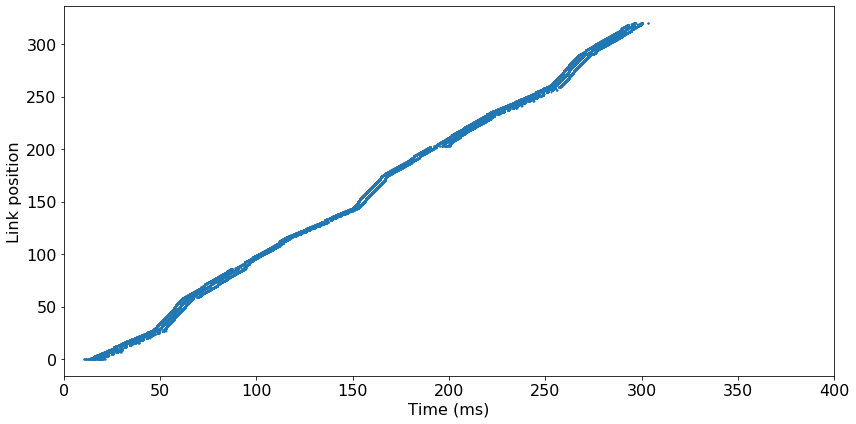

In [9]:
# upstream inputs
spks_u = spks_u_base.copy()
spks_u[:, m.N_L_E:-(m.N_I)] = np.random.poisson(m.FQ_SPK_U * S.DT, (len(t), m.N_E))

ntwk = LIFNtwkG(
    c_m=m.C_M_E,
    g_l=m.G_L_E,
    e_l=m.E_L_E,
    v_th=m.V_TH_E,
    v_r=m.E_L_E,
    t_r=m.T_R_E,
    e_s={'E': m.E_E, 'I': m.E_I, 'A': m.E_A},
    t_s={'E': m.T_E, 'I': m.T_E, 'A': m.T_A},
    w_r=w_r,
    w_u=w_u)

# initial condition
clamp = Generic(v={0: np.repeat(m.E_L_E, m.N_N)}, spk={})

# run smln
rsp = ntwk.run(dt=S.DT, clamp=clamp, i_ext=i_ext, spks_u=spks_u)
rsp.spks_u = spks_u.copy()
rsp.m = copy(m)
    
fig, ax = plt.subplots(1, 1, figsize=(12, 6), tight_layout=True)
spks_t = rsp.spks_t[rsp.spks_c < M.N_E]
spks_c = rsp.spks_c[rsp.spks_c < M.N_E]
spks_x = M.X_E[spks_c]
ax.scatter(1000*spks_t, spks_x, s=1)
ax.set_xlabel('Time (ms)')
ax.set_ylabel('Link position')
set_font_size(ax, 16)
ax.set_xlim(0, 1000*S.T)

# Spatial and temporal modulation together

In [10]:
def make_w_u_e(m):
    w_u_e = np.block([
        [ 0.01 * np.eye(m.N_L_E), np.zeros([m.N_L_E, m.N_N]) ],
        [ np.zeros([m.N_N - m.N_L_E, m.N_N + m.N_L_E]) ],
    ])
    
    w_e_mod = np.zeros((m.N_N, m.N_N))
    
    for l in range(m.N_L):
        if (.25*m.PERIOD_S_U) <= (l%m.PERIOD_S_U) < (.75*m.PERIOD_S_U):
            start = l*m.N_L_E
            end = (l+1)*m.N_L_E
            w_e_mod[start:end, start:end] = m.W_U_E_E*np.eye(m.N_L_E)
    
    w_u_e[:, m.N_L_E:] = w_e_mod
    return csc_matrix(w_u_e)


def make_w_u_i(m):
    w_u_i = np.zeros([m.N_N, m.N_L_E + m.N_N])
    
    w_i_mod = np.zeros((m.N_N, m.N_N))
    
    for l in range(m.N_L):
        if (.25*m.PERIOD_S_U) <= (l%m.PERIOD_S_U) < (.75*m.PERIOD_S_U):
            continue
        else:
            start = l*m.N_L_E
            end = (l+1)*m.N_L_E
            w_i_mod[start:end, start:end] = m.W_U_E_I*np.eye(m.N_L_E)
    
    w_u_i[:, m.N_L_E:] = w_i_mod
    return csc_matrix(w_u_i)

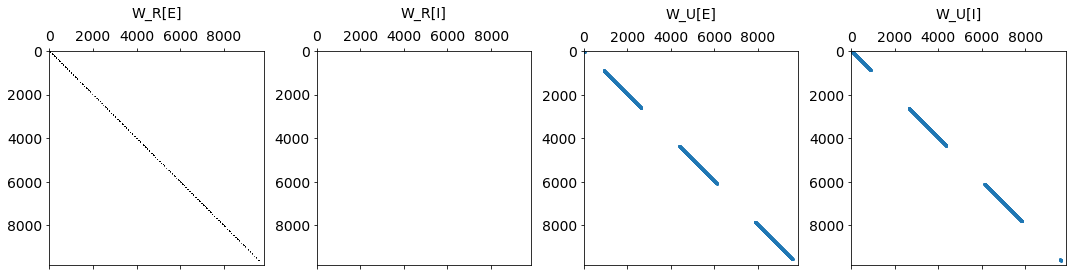

In [11]:
m = copy(M)

np.random.seed(seed=0)

# input weights
w_u = {
    # localized inputs to trigger activation from start of chain
    'E': make_w_u_e(m),

    # global inhibitory inputs across chain
    'I': make_w_u_i(m),
}

# chain weights
w_r = {
    'E': make_w_r_e(m),
    'I': make_w_r_i(m),
    'A': m.W_A * np.eye(m.N_N),
}


fig, axs = plt.subplots(1, 4, figsize=(15, 4), tight_layout=True)
axs[0].matshow(w_r['E'], vmin=0, vmax=10e-6, cmap='binary')
axs[0].set_title('W_R[E]\n')
axs[1].matshow(w_r['I'], vmin=0, vmax=10e-6, cmap='binary')
axs[1].set_title('W_R[I]\n')

axs[2].spy(w_u['E'], markersize=1)
axs[2].set_title('W_U[E]\n')
axs[3].spy(w_u['I'], markersize=1)
axs[3].set_title('W_U[I]\n')

for ax in axs.flatten():
    set_font_size(ax, 14)

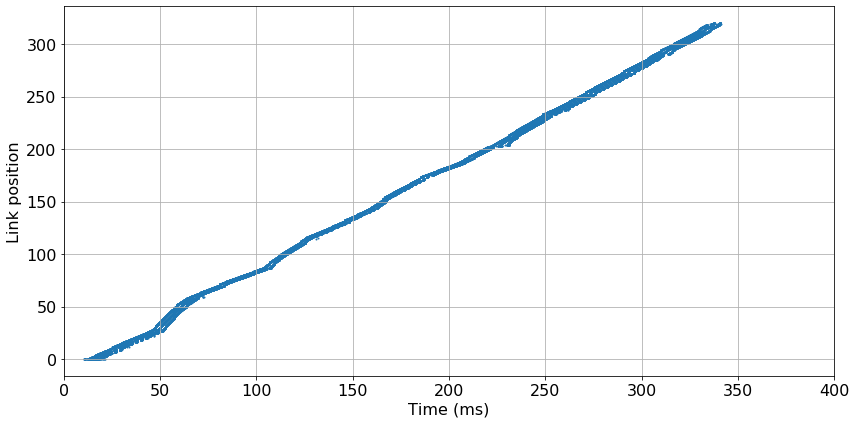

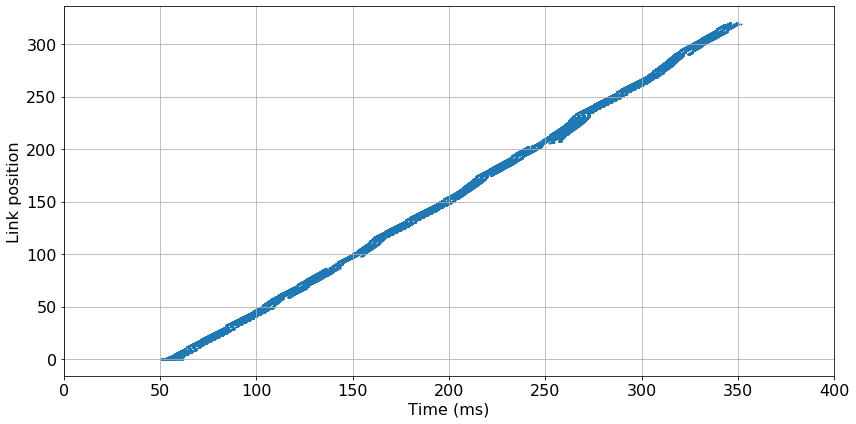

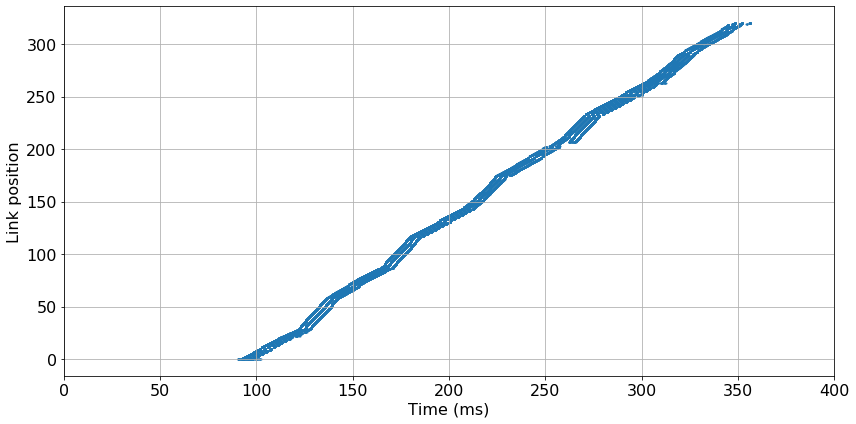

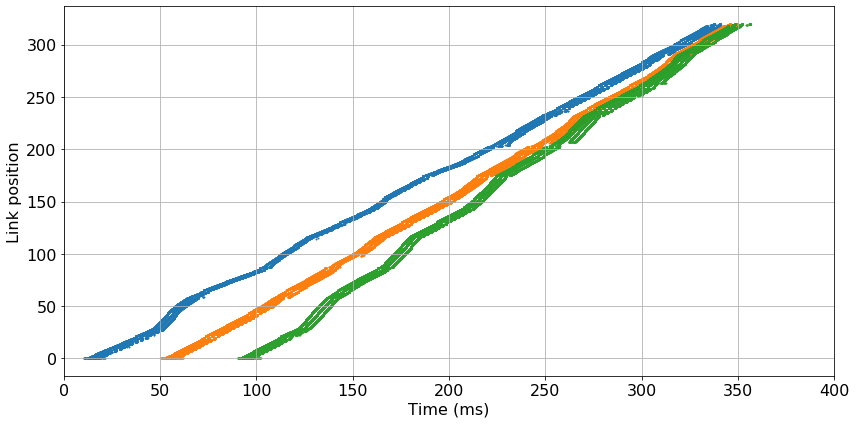

In [12]:
rsps = []
for start in [.01, .05, .09]:

    # inputs
    t = np.arange(0, S.T, S.DT)
    t_u = [start, start+.003]
    t_mask = (t_u[0] <= t) & (t < t_u[1])

    ## external currents
    i_ext = m.SGM_N/S.DT * np.random.randn(len(t), m.N_N) + m.I_EXT_B

    ## inp spks
    spks_u_base = np.zeros((len(t), m.N_L_E + m.N_N), dtype=int)

    # trigger inputs
    tmp = cc([np.ones(m.N_L_E, int), np.zeros(m.N_L_E*(t_mask.sum()-1))])
    spks_u_base[t_mask, :m.N_L_E] = tmp[np.random.permutation(len(tmp))].reshape(t_mask.sum(), m.N_L_E)

    # upstream inputs
    spks_u = spks_u_base.copy()
    # time mask for input rate
    mt = np.sin(2*np.pi*(t - 0.05)/m.PERIOD_T_U) < 0
    spks_u[mt, m.N_L_E:-(m.N_I)] = np.random.poisson(m.FQ_SPK_U * S.DT, (mt.sum(), m.N_E))

    ntwk = LIFNtwkG(
        c_m=m.C_M_E,
        g_l=m.G_L_E,
        e_l=m.E_L_E,
        v_th=m.V_TH_E,
        v_r=m.E_L_E,
        t_r=m.T_R_E,
        e_s={'E': m.E_E, 'I': m.E_I, 'A': m.E_A},
        t_s={'E': m.T_E, 'I': m.T_E, 'A': m.T_A},
        w_r=w_r,
        w_u=w_u)

    # initial condition
    clamp = Generic(v={0: np.repeat(m.E_L_E, m.N_N)}, spk={})

    # run smln
    rsp = ntwk.run(dt=S.DT, clamp=clamp, i_ext=i_ext, spks_u=spks_u)
    rsp.spks_u = spks_u.copy()
    rsp.m = copy(m)

    fig, ax = plt.subplots(1, 1, figsize=(12, 6), tight_layout=True)
    spks_t = rsp.spks_t[rsp.spks_c < M.N_E]
    spks_c = rsp.spks_c[rsp.spks_c < M.N_E]
    spks_x = M.X_E[spks_c]
    ax.scatter(1000*spks_t, spks_x, s=1)
    ax.set_xlabel('Time (ms)')
    ax.set_ylabel('Link position')
    set_font_size(ax, 16)
    ax.set_xlim(0, 1000*S.T)
    ax.grid()

    rsps.append(copy(rsp))

    
fig, ax = plt.subplots(1, 1, figsize=(12, 6), tight_layout=True)

for rsp in rsps:
    spks_t = rsp.spks_t[rsp.spks_c < M.N_E]
    spks_c = rsp.spks_c[rsp.spks_c < M.N_E]
    spks_x = M.X_E[spks_c]
    ax.scatter(1000*spks_t, spks_x, s=1)
ax.set_xlabel('Time (ms)')
ax.set_ylabel('Link position')
set_font_size(ax, 16)
ax.set_xlim(0, 1000*S.T)
ax.grid()

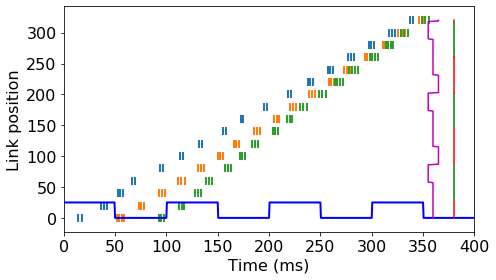

In [13]:
fig, ax = plt.subplots(1, 1, figsize=(7, 4), tight_layout=True)

c_plt = np.linspace(0, 320*M.N_L_E, 17, dtype=int)

for rsp in rsps:
    spks = rsp.spks[:, c_plt]
    spks_t_, spks_c_ = np.nonzero(spks)
    spks_t = spks_t_*S.DT
    spks_c = c_plt[spks_c_]
    spks_x = M.X_E[spks_c]
    ax.scatter(1000*spks_t, spks_x, lw=2, marker='|', s=50)
    
ax.plot(1000*t, mt*25, lw=2, c='b')
w_r_e_e_f_pfl = get_w_r_e_e_f_profile(M)
w_r_e_e_f_pfl -= w_r_e_e_f_pfl.min()
w_r_e_e_f_pfl /= w_r_e_e_f_pfl.max()

w_u_e_pfl, w_u_i_pfl = get_w_u_e_w_u_i_profile(M)
w_u_e_pfl -= w_u_e_pfl.min()
w_u_e_pfl /= w_u_e_pfl.max()
w_u_i_pfl -= w_u_i_pfl.min()
w_u_i_pfl /= w_u_i_pfl.max()

w_u_e_pfl[w_u_e_pfl == 0] = np.nan
w_u_i_pfl[w_u_i_pfl == 0] = np.nan

ax.plot(w_r_e_e_f_pfl*10 + 355, range(M.N_L), c='m')
ax.plot(w_u_e_pfl*10 + 370, range(M.N_L), c='g')
ax.plot(w_u_i_pfl*10 + 370, range(M.N_L), c='r')

ax.set_xlabel('Time (ms)')
ax.set_ylabel('Link position')
set_font_size(ax, 16)
ax.set_xlim(0, 1000*S.T)

fig.savefig('ms/1c.svg')

# Loop over start time and decode position

In [14]:
xs = []
starts = np.arange(.01, .4101, .02)
m = copy(M)
m.N_L = 401
m.N_E = m.N_L * m.N_L_E
m.N_N = m.N_E + m.N_I
m.X_E = cc([np.repeat(cl, m.N_L_E) for cl in range(m.N_L)])

np.random.seed(seed=0)

# input weights
w_u = {
    # localized inputs to trigger activation from start of chain
    'E': make_w_u_e(m),

    # global inhibitory inputs across chain
    'I': make_w_u_i(m),
}

# chain weights
w_r = {
    'E': make_w_r_e(m),
    'I': make_w_r_i(m),
    'A': m.W_A * np.eye(m.N_N),
}

for start in starts:
    sys.stdout.write('.')
    # inputs
    t = np.arange(0, 1., S.DT)
    t_u = [start, start+.003]
    t_mask = (t_u[0] <= t) & (t < t_u[1])

    ## external currents
    i_ext = m.SGM_N/S.DT * np.random.randn(len(t), m.N_N) + m.I_EXT_B

    ## inp spks
    spks_u_base = np.zeros((len(t), m.N_L_E + m.N_N), dtype=int)

    # trigger inputs
    tmp = cc([np.ones(m.N_L_E, int), np.zeros(m.N_L_E*(t_mask.sum()-1))])
    spks_u_base[t_mask, :m.N_L_E] = tmp[np.random.permutation(len(tmp))].reshape(t_mask.sum(), m.N_L_E)

    # upstream inputs
    spks_u = spks_u_base.copy()
    # time mask for input rate
    mt = np.sin(2*np.pi*(t - 0.05)/m.PERIOD_T_U) < 0
    spks_u[mt, m.N_L_E:-(m.N_I)] = np.random.poisson(m.FQ_SPK_U * S.DT, (mt.sum(), m.N_E))

    ntwk = LIFNtwkG(
        c_m=m.C_M_E,
        g_l=m.G_L_E,
        e_l=m.E_L_E,
        v_th=m.V_TH_E,
        v_r=m.E_L_E,
        t_r=m.T_R_E,
        e_s={'E': m.E_E, 'I': m.E_I, 'A': m.E_A},
        t_s={'E': m.T_E, 'I': m.T_E, 'A': m.T_A},
        w_r=w_r,
        w_u=w_u)

    # initial condition
    clamp = Generic(v={0: np.repeat(m.E_L_E, m.N_N)}, spk={})

    # run smln
    rsp = ntwk.run(dt=S.DT, clamp=clamp, i_ext=i_ext, spks_u=spks_u)
    rsp.spks_u = spks_u.copy()
    rsp.m = copy(m)

    xs.append(decode_x(rsp, wdw=.002, min_spk=5))

.....................

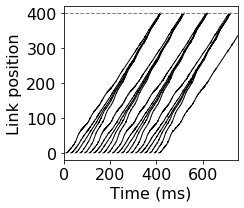

In [15]:
fig, ax = plt.subplots(1, 1, figsize=(3.5, 3), tight_layout=True)

for x in xs:
    ax.plot(1000*t, x, lw=1, c='k')
ax.set_xlabel('Time (ms)')
ax.set_ylabel('Link position')
set_font_size(ax, 16)
ax.set_xlim(0, 750.)
ax.axhline(400, ls='--', lw=1, color='gray')
#ax.grid()

fig.savefig('ms/1d.svg')

# Comparison to unmodulated chain

In [16]:
def make_w_u_e(m):
    w_u_e = np.block([
        [ 0.01 * np.eye(m.N_L_E), np.zeros([m.N_L_E, m.N_N]) ],
        [ np.zeros([m.N_N - m.N_L_E, m.N_N + m.N_L_E]) ],
    ])
    
    w_e_mod = np.zeros((m.N_N, m.N_N))
    
    for l in range(m.N_L):
        if (.25*m.PERIOD_S_U) <= (l%m.PERIOD_S_U) < (.75*m.PERIOD_S_U):
            start = l*m.N_L_E
            end = (l+1)*m.N_L_E
            w_e_mod[start:end, start:end] = m.W_U_E_E*np.eye(m.N_L_E)
    
    w_u_e[:, m.N_L_E:] = w_e_mod
    return csc_matrix(w_u_e)


def make_w_u_i(m):
    w_u_i = np.zeros([m.N_N, m.N_L_E + m.N_N])
    
    w_i_mod = np.zeros((m.N_N, m.N_N))
    
    for l in range(m.N_L):
        if (.25*m.PERIOD_S_U) <= (l%m.PERIOD_S_U) < (.75*m.PERIOD_S_U):
            continue
        else:
            start = l*m.N_L_E
            end = (l+1)*m.N_L_E
            w_i_mod[start:end, start:end] = m.W_U_E_I*np.eye(m.N_L_E)
    
    w_u_i[:, m.N_L_E:] = w_i_mod
    return csc_matrix(w_u_i)

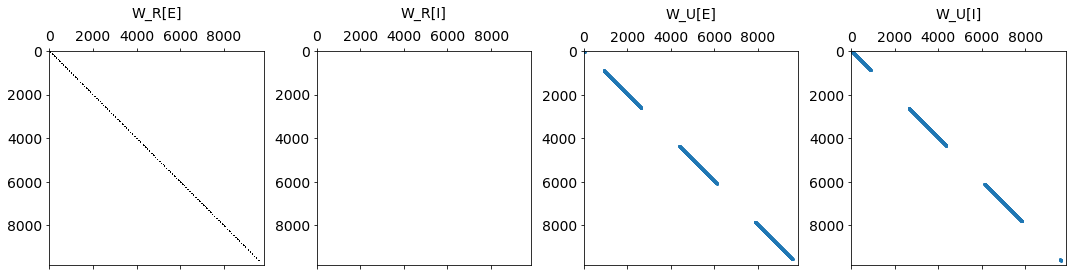

In [17]:
m = copy(M)
m.W_R_E_E_F={'S': 1.05e-5, 'B': 1.05e-5, 'F': 1.05e-5}

np.random.seed(seed=0)

# input weights
w_u = {
    # localized inputs to trigger activation from start of chain
    'E': make_w_u_e(m),

    # global inhibitory inputs across chain
    'I': make_w_u_i(m),
}

# chain weights
w_r = {
    'E': make_w_r_e(m),
    'I': make_w_r_i(m),
    'A': m.W_A * np.eye(m.N_N),
}


fig, axs = plt.subplots(1, 4, figsize=(15, 4), tight_layout=True)
axs[0].matshow(w_r['E'], vmin=0, vmax=10e-6, cmap='binary')
axs[0].set_title('W_R[E]\n')
axs[1].matshow(w_r['I'], vmin=0, vmax=10e-6, cmap='binary')
axs[1].set_title('W_R[I]\n')

axs[2].spy(w_u['E'], markersize=1)
axs[2].set_title('W_U[E]\n')
axs[3].spy(w_u['I'], markersize=1)
axs[3].set_title('W_U[I]\n')

for ax in axs.flatten():
    set_font_size(ax, 14)

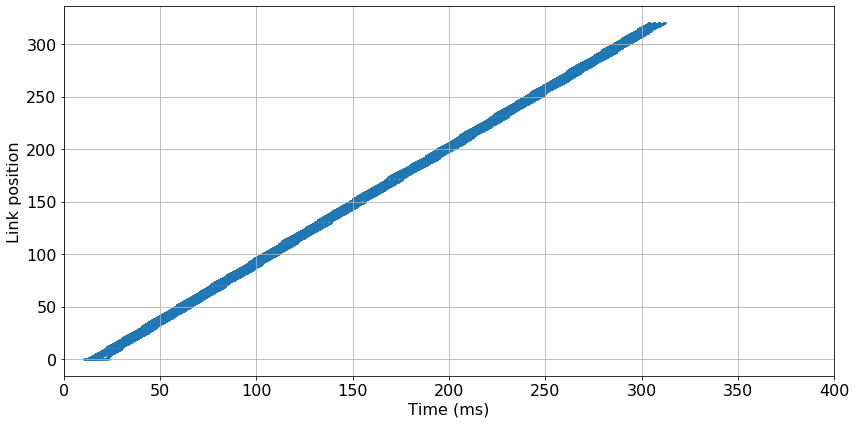

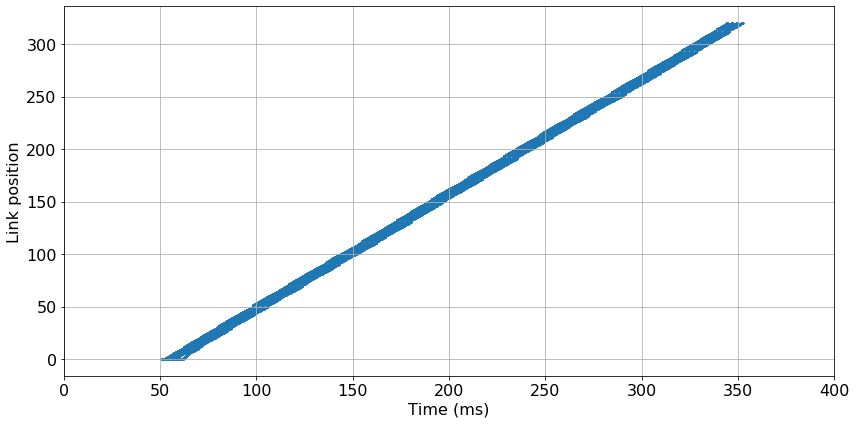

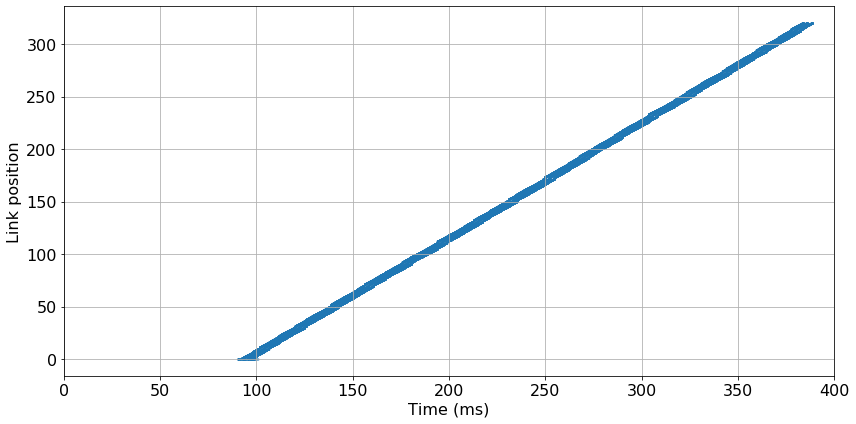

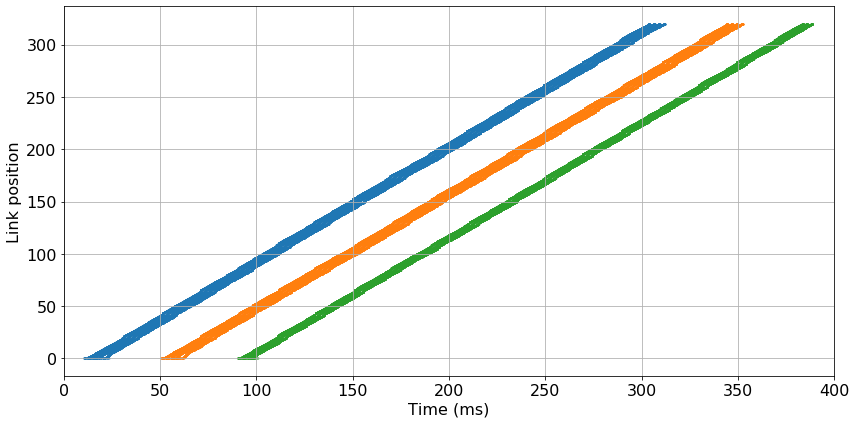

In [18]:
rsps = []
for start in [.01, .05, .09]:

    # inputs
    t = np.arange(0, S.T, S.DT)
    t_u = [start, start+.003]
    t_mask = (t_u[0] <= t) & (t < t_u[1])

    ## external currents
    i_ext = m.SGM_N/S.DT * np.random.randn(len(t), m.N_N) + m.I_EXT_B

    ## inp spks
    spks_u_base = np.zeros((len(t), m.N_L_E + m.N_N), dtype=int)

    # trigger inputs
    tmp = cc([np.ones(m.N_L_E, int), np.zeros(m.N_L_E*(t_mask.sum()-1))])
    spks_u_base[t_mask, :m.N_L_E] = tmp[np.random.permutation(len(tmp))].reshape(t_mask.sum(), m.N_L_E)

    # upstream inputs
    spks_u = spks_u_base.copy()

    ntwk = LIFNtwkG(
        c_m=m.C_M_E,
        g_l=m.G_L_E,
        e_l=m.E_L_E,
        v_th=m.V_TH_E,
        v_r=m.E_L_E,
        t_r=m.T_R_E,
        e_s={'E': m.E_E, 'I': m.E_I, 'A': m.E_A},
        t_s={'E': m.T_E, 'I': m.T_E, 'A': m.T_A},
        w_r=w_r,
        w_u=w_u)

    # initial condition
    clamp = Generic(v={0: np.repeat(m.E_L_E, m.N_N)}, spk={})

    # run smln
    rsp = ntwk.run(dt=S.DT, clamp=clamp, i_ext=i_ext, spks_u=spks_u)
    rsp.spks_u = spks_u.copy()
    rsp.m = copy(m)

    fig, ax = plt.subplots(1, 1, figsize=(12, 6), tight_layout=True)
    spks_t = rsp.spks_t[rsp.spks_c < M.N_E]
    spks_c = rsp.spks_c[rsp.spks_c < M.N_E]
    spks_x = M.X_E[spks_c]
    ax.scatter(1000*spks_t, spks_x, s=1)
    ax.set_xlabel('Time (ms)')
    ax.set_ylabel('Link position')
    set_font_size(ax, 16)
    ax.set_xlim(0, 1000*S.T)
    ax.grid()

    rsps.append(copy(rsp))

    
fig, ax = plt.subplots(1, 1, figsize=(12, 6), tight_layout=True)

for rsp in rsps:
    spks_t = rsp.spks_t[rsp.spks_c < M.N_E]
    spks_c = rsp.spks_c[rsp.spks_c < M.N_E]
    spks_x = M.X_E[spks_c]
    ax.scatter(1000*spks_t, spks_x, s=1)
ax.set_xlabel('Time (ms)')
ax.set_ylabel('Link position')
set_font_size(ax, 16)
ax.set_xlim(0, 1000*S.T)
ax.grid()

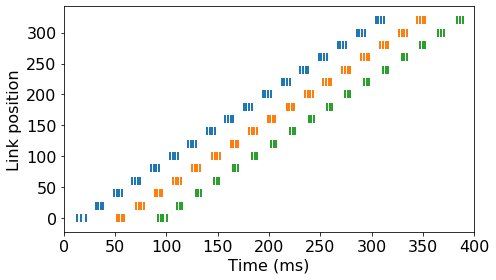

In [19]:
fig, ax = plt.subplots(1, 1, figsize=(7, 4), tight_layout=True)

c_plt = np.linspace(0, 320*M.N_L_E, 17, dtype=int)

for rsp in rsps:
    spks = rsp.spks[:, c_plt]
    spks_t_, spks_c_ = np.nonzero(spks)
    spks_t = spks_t_*S.DT
    spks_c = c_plt[spks_c_]
    spks_x = M.X_E[spks_c]
    ax.scatter(1000*spks_t, spks_x, lw=2, marker='|', s=50)
ax.set_xlabel('Time (ms)')
ax.set_ylabel('Link position')
set_font_size(ax, 16)
ax.set_xlim(0, 1000*S.T)

fig.savefig('ms/1b.svg')

# Vary speed under different modulation strengths

In [20]:
def make_w_u_e(m):
    w_u_e = np.block([
        [ 0.01 * np.eye(m.N_L_E), np.zeros([m.N_L_E, m.N_N]) ],
        [ np.zeros([m.N_N - m.N_L_E, m.N_N + m.N_L_E]) ],
    ])
    
    w_e_mod = np.zeros((m.N_N, m.N_N))
    w_e_mod[:m.N_E, :m.N_E] = m.W_U_E_E*np.eye(m.N_E)
    
    w_u_e[:, m.N_L_E:] = w_e_mod
    return csc_matrix(w_u_e)


def make_w_u_i(m):
    w_u_i = np.zeros([m.N_N, m.N_L_E + m.N_N])
    
    w_i_mod = np.zeros((m.N_N, m.N_N))
    w_i_mod[:m.N_E, :m.N_E] = m.W_U_E_I*np.eye(m.N_E)
    
    w_u_i[:, m.N_L_E:] = w_i_mod
    return csc_matrix(w_u_i)

-800...................0...................800...................

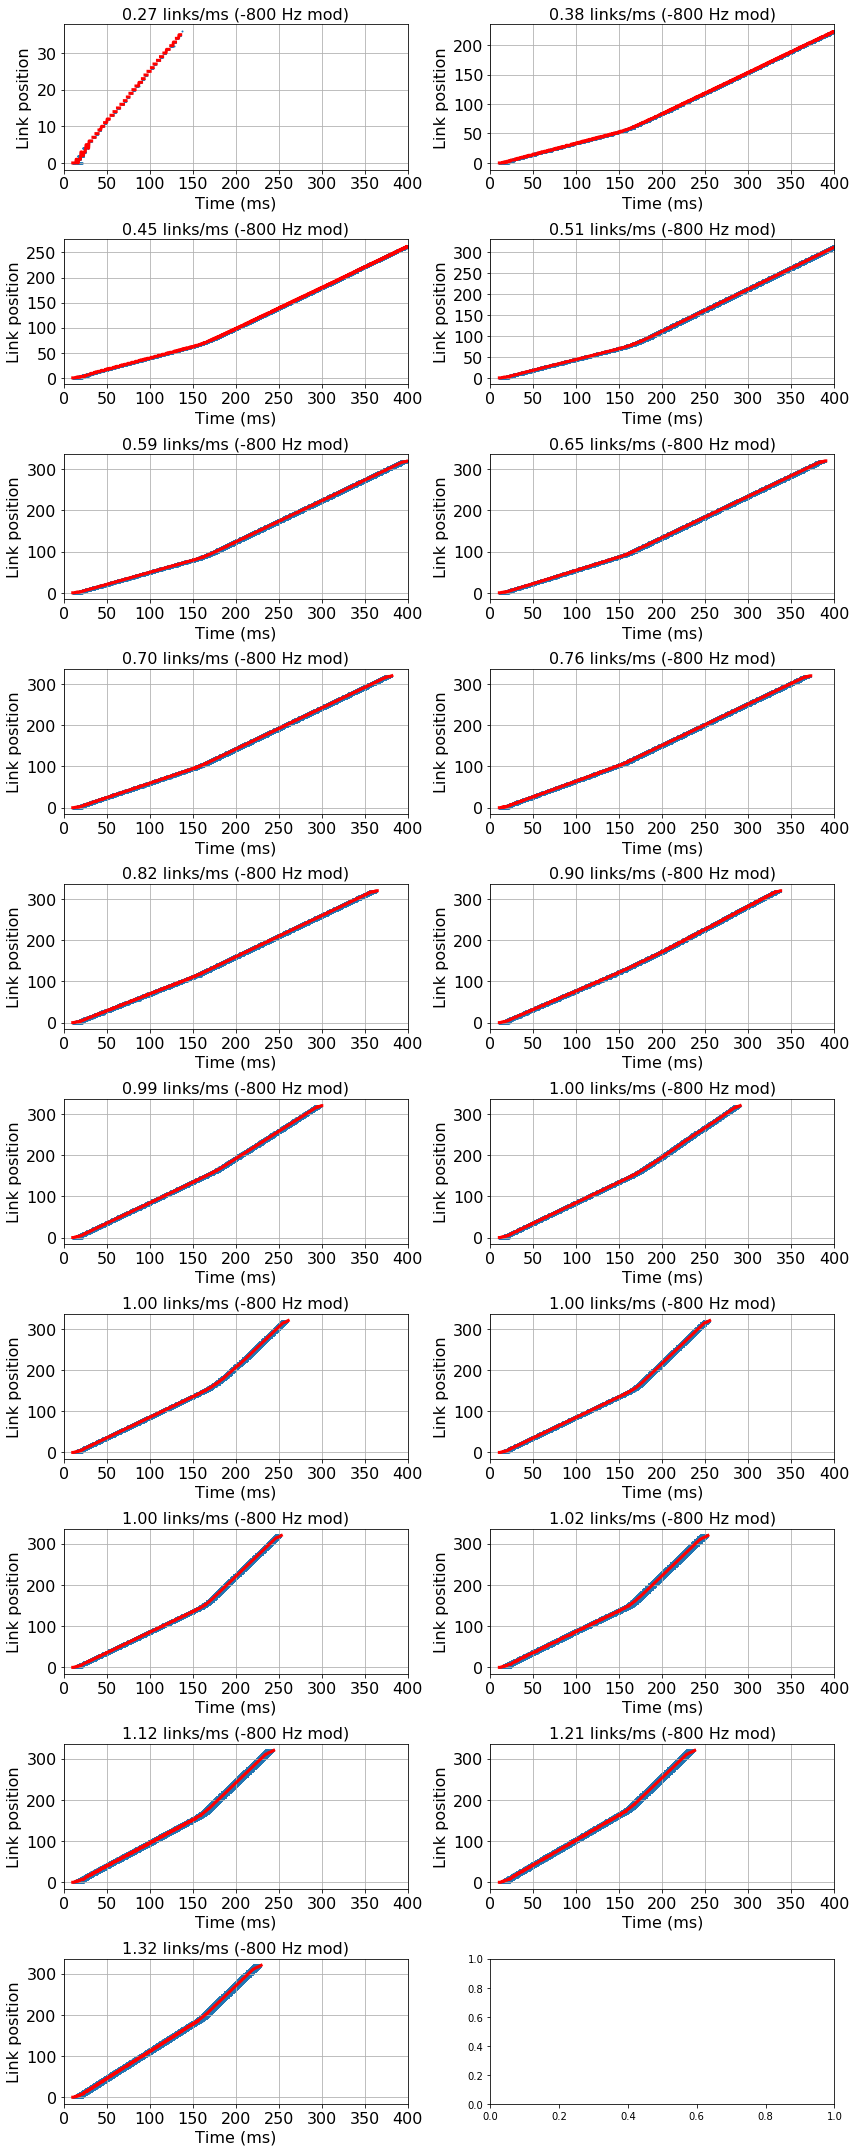

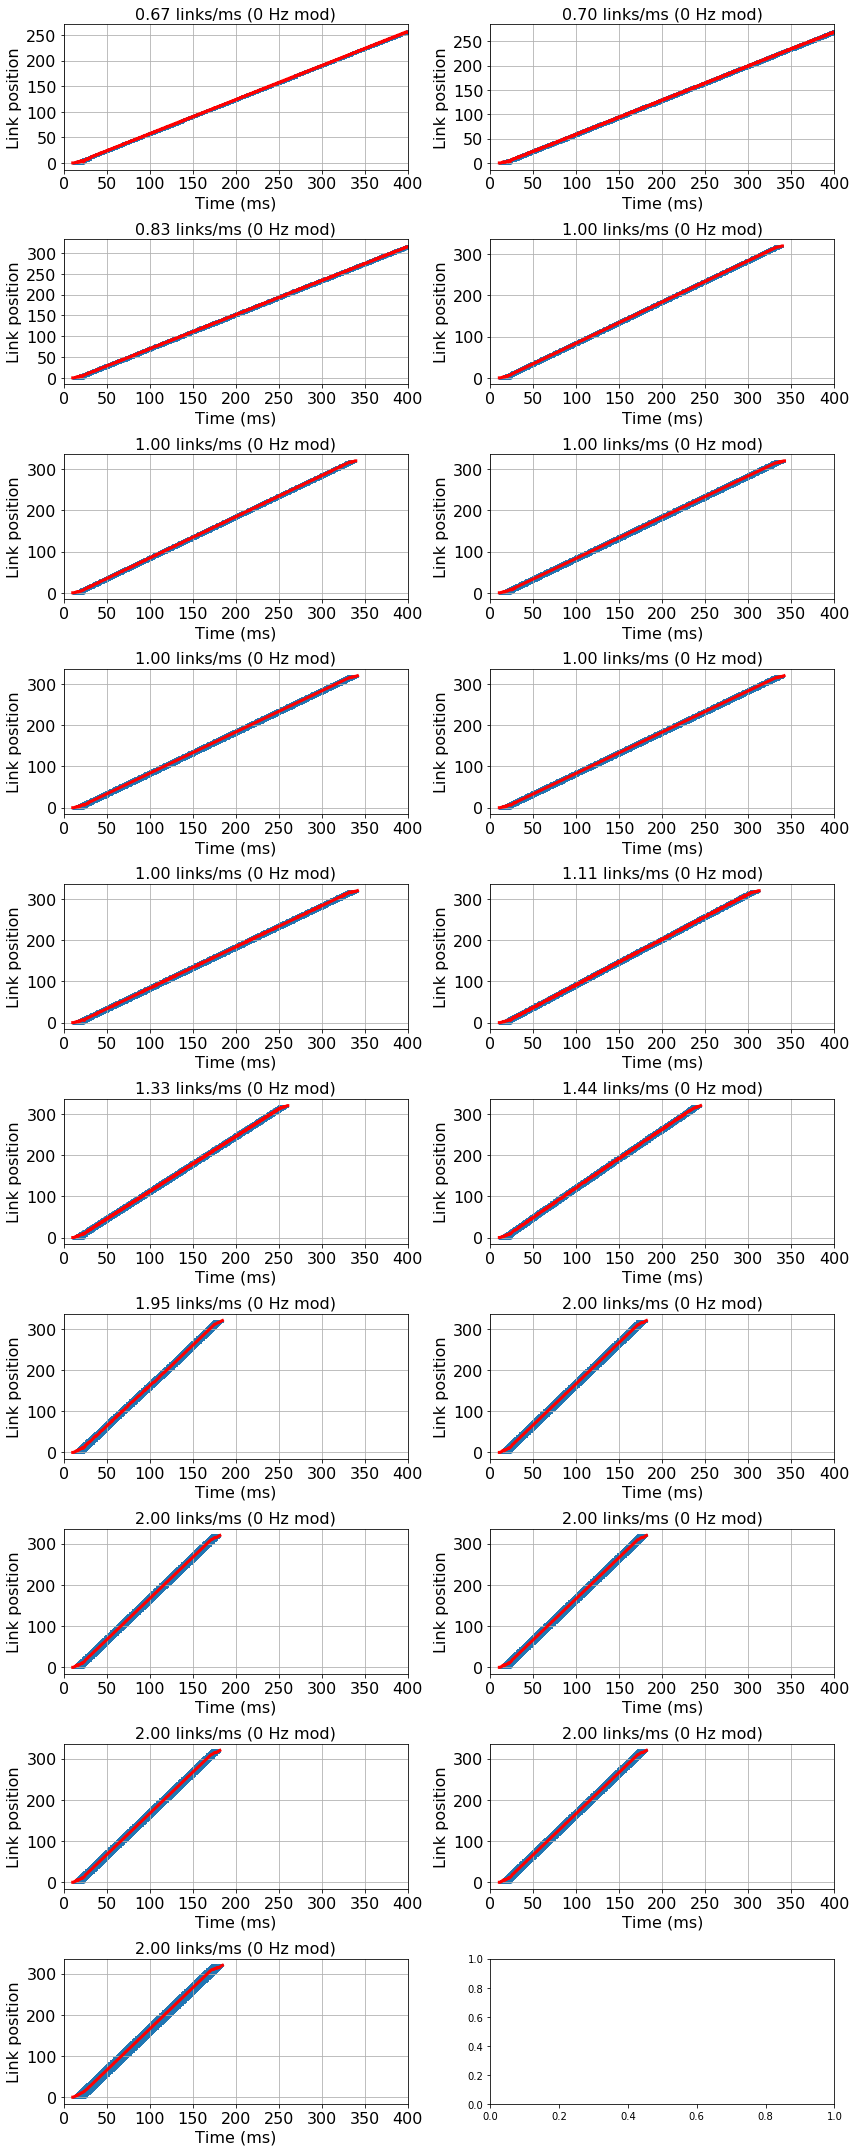

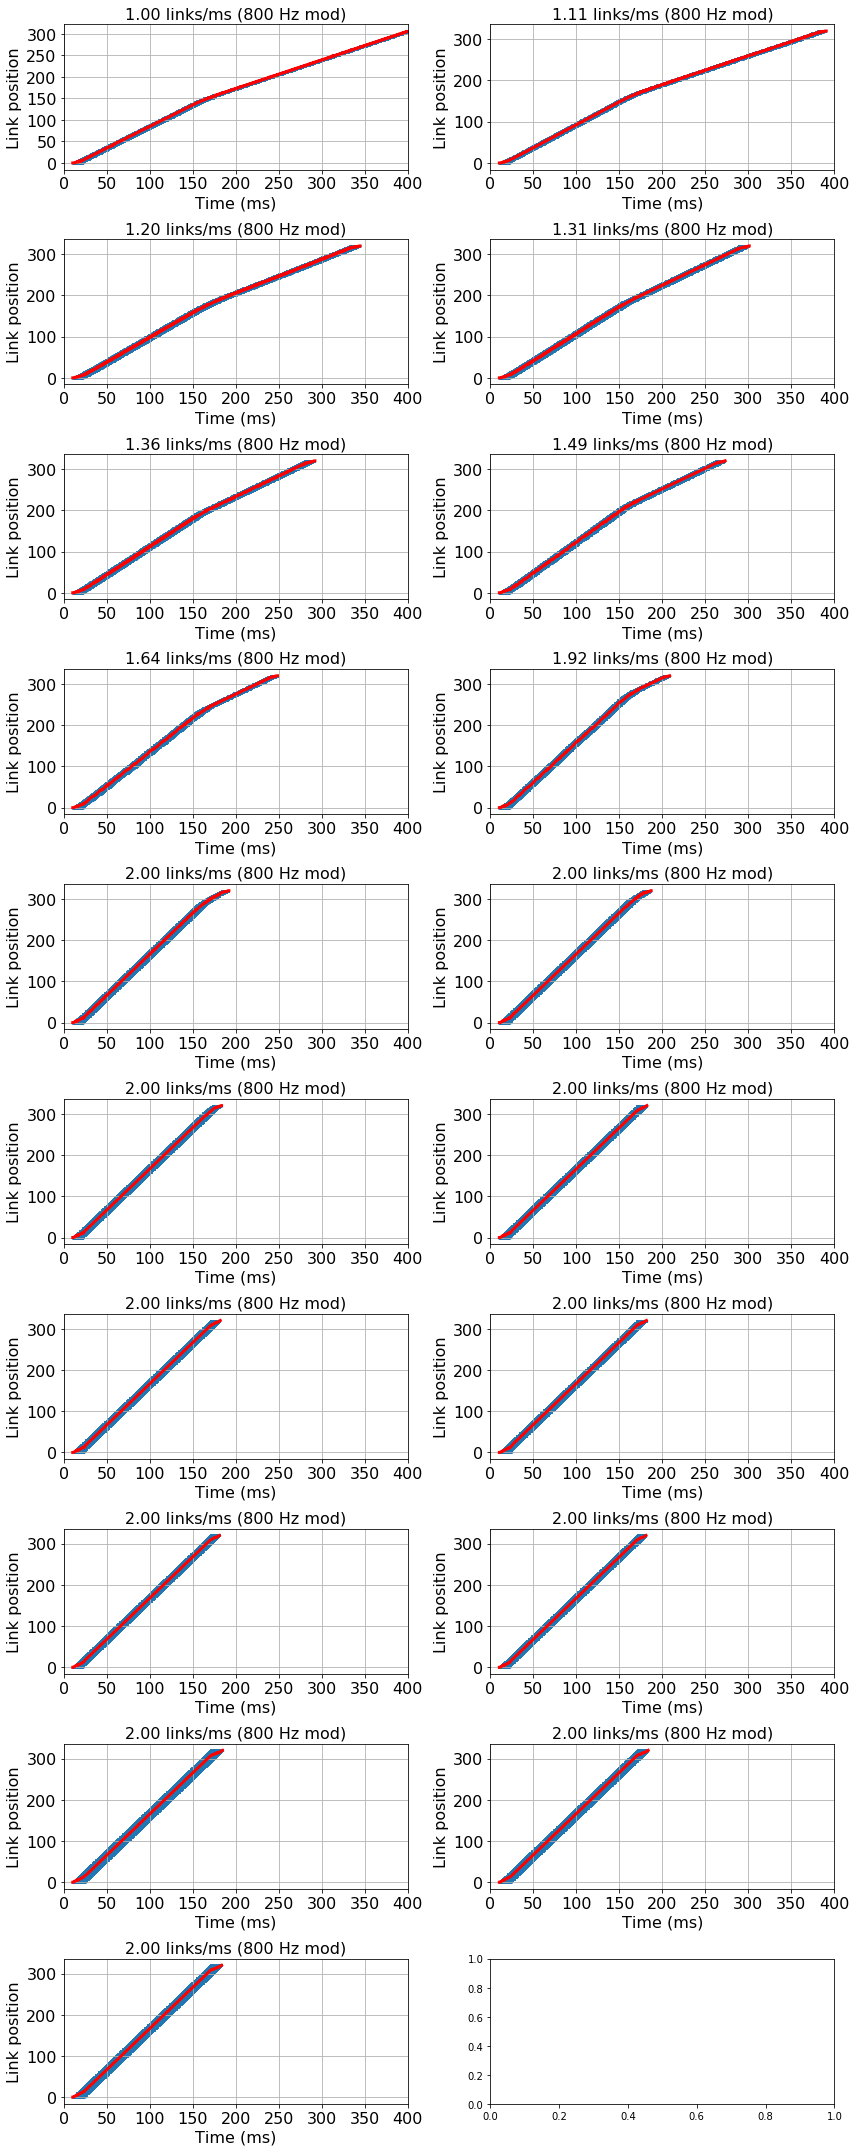

In [21]:
FQ_SPK_U = [-800, 0, 800]
W_R_E_E_F = np.arange(.6, 1.51, .05) * 1e-5
#W_R_E_E_F = np.array([.6, 1., 1.4]) * 1e-5
START = 0.01

MOD_STOP = .15

v = {fq: [] for fq in FQ_SPK_U}
x_lb = 25
x_ub = 300


for fq_spk_u in FQ_SPK_U:
    sys.stdout.write(f'{fq_spk_u}')
    m = copy(M)
    
    if fq_spk_u < 0:
        m.W_U_E_E = 0
        m.W_U_E_I = M.W_U_E_I
    elif fq_spk_u > 0:
        m.W_U_E_E = M.W_U_E_E
        m.W_U_E_I = 0
        
    m.FQ_SPK_U = np.abs(fq_spk_u)
    
    n_row = int(np.ceil(len(W_R_E_E_F)/2))
    fig, axs = plt.subplots(n_row, 2, figsize=(12, 3*n_row), tight_layout=True)

    for w_r_e_e_f, ax in zip(W_R_E_E_F, axs.flatten()):
        sys.stdout.write('.')
        m.W_R_E_E_F={'S': w_r_e_e_f, 'B': w_r_e_e_f, 'F': w_r_e_e_f}

        np.random.seed(seed=0)

        # input weights
        w_u = {
            # localized inputs to trigger activation from start of chain
            'E': make_w_u_e(m),

            # global inhibitory inputs across chain
            'I': make_w_u_i(m),
        }

        # chain weights
        w_r = {
            'E': make_w_r_e(m),
            'I': make_w_r_i(m),
            'A': m.W_A * np.eye(m.N_N),
        }


        # inputs
        t = np.arange(0, S.T, S.DT)
        t_u = [START, START+.003]
        t_mask = (t_u[0] <= t) & (t < t_u[1])

        ## external currents
        i_ext = m.SGM_N/S.DT * np.random.randn(len(t), m.N_N) + m.I_EXT_B

        ## inp spks
        spks_u_base = np.zeros((len(t), m.N_L_E + m.N_N), dtype=int)

        # trigger inputs
        tmp = cc([np.ones(m.N_L_E, int), np.zeros(m.N_L_E*(t_mask.sum()-1))])
        spks_u_base[t_mask, :m.N_L_E] = tmp[np.random.permutation(len(tmp))].reshape(t_mask.sum(), m.N_L_E)

        # upstream inputs
        spks_u = spks_u_base.copy()

        # time mask for input rate
        mt = t < MOD_STOP
        spks_u[mt, m.N_L_E:-(m.N_I)] = np.random.poisson(m.FQ_SPK_U * S.DT, (mt.sum(), m.N_E))


        ntwk = LIFNtwkG(
            c_m=m.C_M_E,
            g_l=m.G_L_E,
            e_l=m.E_L_E,
            v_th=m.V_TH_E,
            v_r=m.E_L_E,
            t_r=m.T_R_E,
            e_s={'E': m.E_E, 'I': m.E_I, 'A': m.E_A},
            t_s={'E': m.T_E, 'I': m.T_E, 'A': m.T_A},
            w_r=w_r,
            w_u=w_u)

        # initial condition
        clamp = Generic(v={0: np.repeat(m.E_L_E, m.N_N)}, spk={})

        # run smln
        rsp = ntwk.run(dt=S.DT, clamp=clamp, i_ext=i_ext, spks_u=spks_u)
        rsp.spks_u = spks_u.copy()
        rsp.m = copy(m)

        x = decode_x(rsp, wdw=.002, min_spk=5)
        mx = (x_lb <= x)&(x < x_ub)
        mt = t <= MOD_STOP
        v_ = stats.linregress(t[mx&mt], x[mx&mt])[0]

        v[fq_spk_u].append(v_)

        spks_t = rsp.spks_t[rsp.spks_c < M.N_E]
        spks_c = rsp.spks_c[rsp.spks_c < M.N_E]
        spks_x = M.X_E[spks_c]
        ax.scatter(1000*spks_t, spks_x, s=1)
        ax.plot(1000*t, x, lw=3, c='r')
        ax.set_xlabel('Time (ms)')
        ax.set_ylabel('Link position')
        ax.set_title(f'{v_/1000:.2f} links/ms ({fq_spk_u} Hz mod)')
        set_font_size(ax, 16)
        ax.set_xlim(0, 1000*S.T)
        ax.grid()

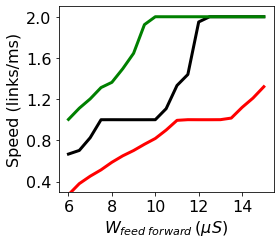

In [22]:
fig, ax = plt.subplots(1, 1, figsize=(4, 3.5), tight_layout=True)
c = ['r', 'k', 'g']

for fq_spk_u, c_ in zip(FQ_SPK_U, c):
    ax.plot(1e6*W_R_E_E_F, np.array(v[fq_spk_u])/1000, c=c_, lw=3)

ax.set_ylim(0.3, 2.1)
ax.set_yticks([.4, .8, 1.2, 1.6, 2.0])
ax.set_xlabel('$W_{feed\; forward} \: (\mu S)$')
ax.set_ylabel('Speed (links/ms)')
set_font_size(ax, 16)

fig.savefig('ms/1e.svg')

# Plot sequence attractor trajectories